# CIFAR 10

In [55]:
import numpy as np
import pandas as pd
from quantification.dm import HDX, EDx
from quantification.metrics import absolute_error
from quantification.utils.validation import create_bags_with_multiple_prevalence

from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import permutations

## Load data

In [2]:
from keras.datasets import cifar10

X_train = np.loadtxt("deeplearning/X_train_cifar.csv", delimiter=',')
Xp_train = np.loadtxt("deeplearning/y_train_cifar.csv", delimiter=',')
X_test = np.loadtxt("deeplearning/X_test_cifar.csv", delimiter=',')
Xp_test = np.loadtxt("deeplearning/y_test_cifar.csv", delimiter=',')
(_, y_train), (_, y_test) = cifar10.load_data()
y_train = y_train.squeeze()
y_test = y_test.squeeze()


/home/castano/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Prepare results

In [3]:
columns=['method', 'truth', 'prediction', 'mae']
errors_df = pd.DataFrame(columns=columns)
prevs_per_method = 100

## HDX

In [4]:
hdx = HDX(b=8)
hdx.fit(X_train, y_train)
for X_test_, y_test_, prev_true in tqdm(create_bags_with_multiple_prevalence(X_test, y_test, prevs_per_method), total=prevs_per_method):
    prev_pred = hdx.predict(X_test_)

    mae = np.mean(absolute_error(prev_true, prev_pred))
    errors_df = errors_df.append(pd.DataFrame([['HDX', prev_true, prev_pred, mae]], columns=columns))

100%|██████████| 100/100 [00:52<00:00,  1.91it/s]


## HDy

Here, we use HDx with the probabilistic representation of Cifar10 images as the X.

In [5]:
hdy = HDX(b=8)
hdy.fit(Xp_train, y_train)
for X_test_, y_test_, prev_true in tqdm(create_bags_with_multiple_prevalence(Xp_test, y_test, prevs_per_method), total=prevs_per_method):
    prev_pred = hdy.predict(X_test_)

    mae = np.mean(absolute_error(prev_true, prev_pred))
    errors_df = errors_df.append(pd.DataFrame([['HDy', prev_true, prev_pred, mae]], columns=columns))

100%|██████████| 100/100 [00:01<00:00, 62.81it/s]


## EDx

In [6]:
edx = EDx()
edx.fit(X_train, y_train)
for X_test_, y_test_, prev_true in tqdm(create_bags_with_multiple_prevalence(X_test, y_test, prevs_per_method), total=prevs_per_method):
    prev_pred = edx.predict(X_test_)

    mae = np.mean(absolute_error(prev_true, prev_pred))
    errors_df = errors_df.append(pd.DataFrame([['EDX', prev_true, prev_pred, mae]], columns=columns))

100%|██████████| 100/100 [13:29<00:00,  8.10s/it]


## EDy

Here, we use EDx with the probabilistic representation of Cifar10 images as the X.

In [7]:
edy = EDx()
edy.fit(Xp_train, y_train)
for X_test_, y_test_, prev_true in tqdm(create_bags_with_multiple_prevalence(Xp_test, y_test, prevs_per_method), total=prevs_per_method):
    prev_pred = edy.predict(X_test_)

    mae = np.mean(absolute_error(prev_true, prev_pred))
    errors_df = errors_df.append(pd.DataFrame([['EDy', prev_true, prev_pred, mae]], columns=columns))

100%|██████████| 100/100 [20:44<00:00, 12.44s/it]


## Results

In [99]:
errors_df.reset_index(drop=True, inplace=True)
errors_df.groupby(['method'])[['mae']].agg(['mean', 'median'])

mae          
            mean    median
method                    
EDX     0.003673  0.003685
EDy     0.003989  0.003949
HDX     0.003619  0.003494
HDy     0.004681  0.004679

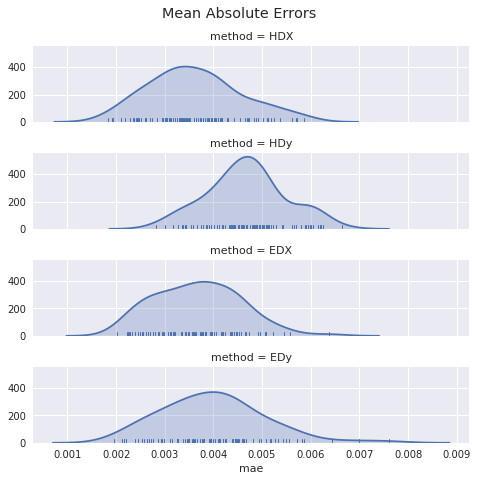

In [53]:
g = sns.FacetGrid(errors_df, row="method", row_order=errors_df.method.unique(),
                  size=1.7, aspect=4,)

_ = g.map(sns.kdeplot, "mae",  shade=True)
_ = g.map(sns.rugplot, "mae")

plt.subplots_adjust(top=0.9)
_ = g.fig.suptitle('Mean Absolute Errors') # can also get the figure from plt.gcf()

/home/castano/.local/lib/python3.5/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


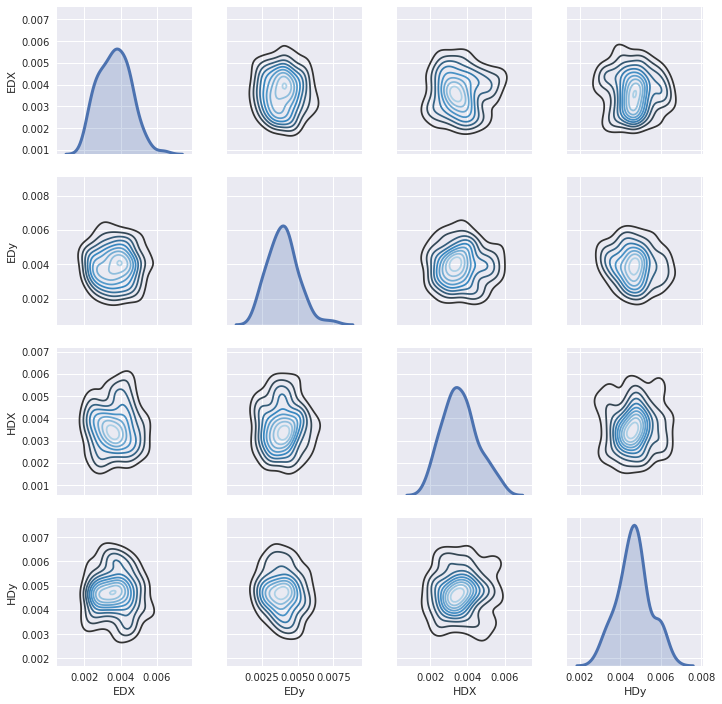

In [112]:
df = errors_df.pivot_table(values='mae', columns='method', index=np.tile(np.arange(100), 4))
g = sns.PairGrid(df)
g.map_upper(sns.kdeplot, cmap="Blues_d")
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_diag(sns.kdeplot, lw=3, legend=False, shade=True)

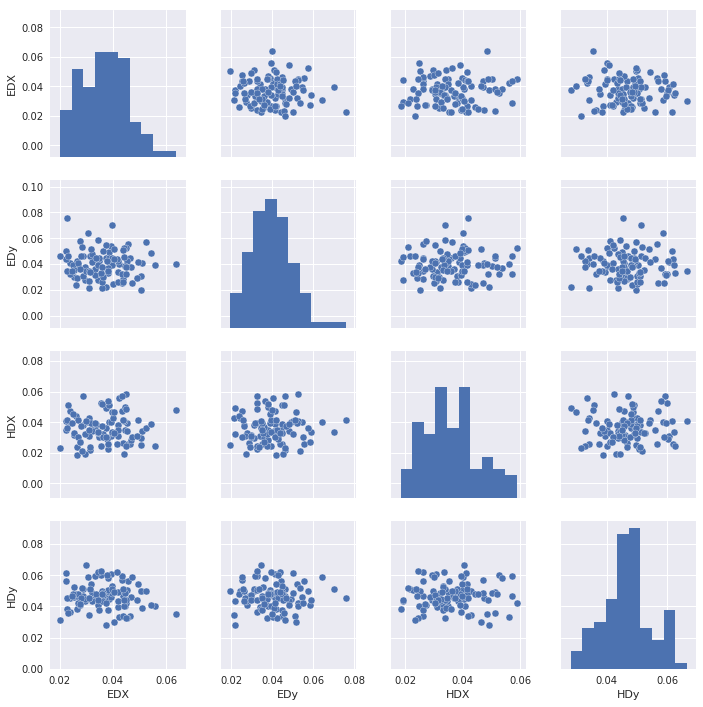

In [114]:
sns.pairplot(df*10, size=2.5)